Here i can write what happends in the cell below

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Read the data

In [2]:
df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')

# Step 2: Extract the text data (adjust column name to your CSV structure)
sentences = df['text'].tolist()


<>:1: SyntaxWarning: invalid escape sequence '\Q'
<>:1: SyntaxWarning: invalid escape sequence '\Q'
C:\Users\gonor\AppData\Local\Temp\ipykernel_35088\3844972058.py:1: SyntaxWarning: invalid escape sequence '\Q'
  df = pd.read_csv('data\QAQC\swe_qaqc_train.csv')


c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 171/171 [00:13<00:00, 12.39it/s]
c:\Users\gonor\D7017E - projekt datateknik\ISBiT\envISBIT\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


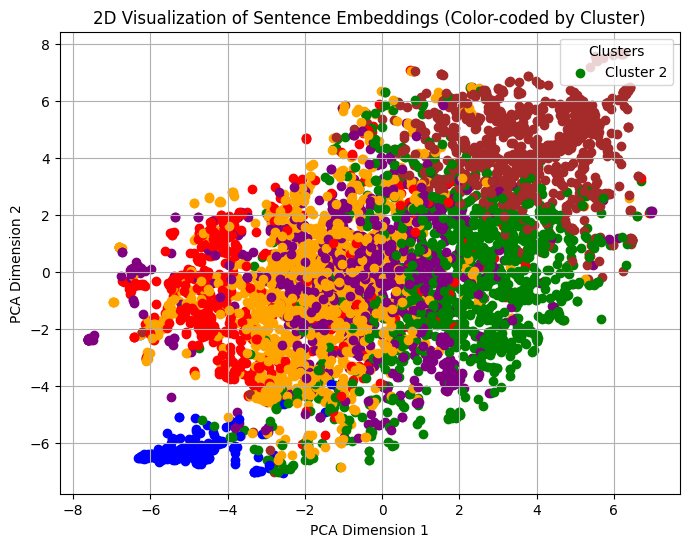

                                                text verbose label  \
0              Hur utvecklades träldomen i Ryssland?   DESC:manner   
1  Vilka filmer inkluderade karaktären Popeye Doyle?   ENTY:cremat   
2  Hur kan jag hitta en lista över kändisars rikt...   DESC:manner   
3  Vilken fjäderfä fångar rampljuset efter det ki...   ENTY:animal   
4            Vad är den fullständiga formen av .com?      ABBR:exp   

   coarse label  fine label  
0             2           4  
1             3           9  
2             2           4  
3             3           6  
4             4           1  


In [3]:



# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# # Load the CSV file into a DataFrame
# df = pd.read_csv('ML/swe_qaqc_train.csv')

# # Print the first 5 rows of the DataFrame to verify the contents
# print(df.head())
# # Load a pre-trained SBERT model
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # List of sentences to encode
# sentences = df['text'].tolist()

# # Get sentence embeddings
# embeddings = model.encode(sentences, show_progress_bar=True)
# # pca = PCA(n_components=2)
# # embedding_2d = pca.fit_transform(embeddings)
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# embedding_2d = tsne.fit_transform(embeddings)


# # Print the embeddings
# #for sentence, embedding in zip(sentences, embeddings):
# #    print(f"Sentence: {sentence}")
# #    print(f"Embedding: {embedding[:1]}...")  # Print the first 5 dimensions of the embedding for brevity
# #    print()
# #print(f"Embedding dimensions: {len(embeddings[0])}")
# for i, (sentence, embedding) in enumerate(zip(sentences, embeddings)):
#     if i >= 10:
#         break  # Stop after printing 10 sentences
#     print(f"Sentence {i + 1}: {sentence}")
#     print(f"Embedding {i + 1} (first 5 dimensions): {embedding[:5]}\n")
# plt.figure(figsize=(8, 6))
# for i, sentence in enumerate(sentences):
#     plt.scatter(embedding_2d[i, 0], embedding_2d[i, 1])
#     #plt.text(embedding_2d[i, 0] + 0.01, embedding_2d[i, 1] + 0.01, sentence[:20], fontsize=9)  # Display the first 20 chars of the sentence

# plt.title("2D Visualization of Sentence Embeddings")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.grid(True)
# plt.show()




# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# Step 1: Load the CSV file into a DataFrame (adjust path and column as needed)

# Step 3: Load a pre-trained SBERT model




# ##.\envISBIT\Scripts\activate to activate my virtual environment
# ## "deactivate" to deactivate it
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Step 4: Generate embeddings for the extracted sentences
embeddings = model.encode(sentences, show_progress_bar=True)

# Step 5: Use KMeans to cluster the embeddings into 3 clusters
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

# Get the cluster labels (0, 1, 2) for each embedding
cluster_labels = kmeans.labels_

# Step 6: Define a color map to assign colors to clusters
color_map = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'purple',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'olive',
    9: 'cyan'
}
colors = [color_map[label] for label in cluster_labels]

# Step 7: Apply PCA to reduce the embeddings to 2D for visualization
from sklearn.decomposition import PCA
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embeddings)

# Step 8: Plot the 2D embeddings with color-coding by cluster
plt.figure(figsize=(8, 6))
for i, (embedding, cluster_label) in enumerate(zip(embedding_2d, cluster_labels)):
    plt.scatter(embedding[0], embedding[1], color=colors[i], label=f'Cluster {cluster_label}' if i == 0 else "")
    #plt.text(embedding[0] + 0.01, embedding[1] + 0.01, f"Point {i+1}", fontsize=9)


#
#inputdata ska vara en tuple med (string, label), där label=NIL om den inte assignats än. 
#forloop:
#   inputdata=modification(inputdata)  //modification ska kolla på en del av tuplerna, säg ("Hur utvecklades träldomen i Ryssland?",NIL) och omvandla den till ("Hur utvecklades träldomen i Ryssland?",DESC)
#   LabelPropagation(inputData)
#

# Add legend and labels
plt.legend(loc='upper right', title="Clusters")
plt.title("2D Visualization of Sentence Embeddings (Color-coded by Cluster)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()
print(df.head())



In [4]:
print(sentences[1:19])

['Vilka filmer inkluderade karaktären Popeye Doyle?', 'Hur kan jag hitta en lista över kändisars riktiga namn?', 'Vilken fjäderfä fångar rampljuset efter det kinesiska apans år?', 'Vad är den fullständiga formen av .com?', 'Vilken föraktlig skurk stal korken från min lunch?', 'Vilket lag blev basebollens St. Louis Browns?', 'Vad är det äldsta yrket?', 'Vad är leverenzymer?', 'Namnge den ärriga prisjägaren i The Old West.', 'När föddes Ozzy Osbourne?', 'Varför faller tyngre föremål snabbare nedåt?', 'Vem var Yankees stolthet?', 'Vem dödade Gandhi?', 'Vad anses vara den dyraste katastrofen som försäkringsbranschen någonsin har stött på?', 'Vilken utbredd amerikansk stat har flest flygplatser?', 'Vad behandlade den enda upphävda ändringen av USA:s konstitution?', 'Hur många judar avrättades i koncentrationsläger under andra världskriget?', 'Vad är Nine Inch Nails"?"']
